#Инициализация

In [1]:
!pip install --index-url https://repo.qboard.tech/ qboard-client

Looking in indexes: https://repo.qboard.tech/


In [2]:
from qboard import Solver
PARAMS = {
    "remote_addr": "https://remote.qboard.tech", 
    "access_key": "0878a0b9-0bda-499b-b74f-ad105357239e"
}
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

#Генерация матрицы смежности

In [3]:
# вводим условие из задания
connections = [('A', 'R'), ('A', 'U'),  
('B', 'G'), ('B', 'O'), 
('C', 'E'), ('C', 'M'), ('C', 'P'),
('E', 'G'), ('E', 'P'),
('G', 'P'),
('I', 'A'), ('I', 'N'),
('J', 'E'), ('J', 'S'), 
('L', 'N'), 
('M', 'D'), ('M', 'U'),  
('N', 'P'), ('N', 'R'),
('O', 'A'), ('O', 'D'),
('Q', 'B'), ('Q', 'G'), ('Q', 'L'), 
('R', 'D'),
('S', 'G'), ('S', 'M'), ('S', 'N'), ('S', 'P'), ('S', 'U')]
len(connections)

30

In [4]:
# собираем список имен вершин
letters = []                        
for pairs in connections:
  if pairs[0] not in letters:
    letters.append(pairs[0])
  if pairs[1] not in letters:
    letters.append(pairs[1])

letters = np.sort(letters)
N = len(letters)

In [5]:
#каст из букв в номера
def ch_int(x):
  return list(letters).index(x)

In [6]:
#собираем матрицу смежности
w = np.zeros((N,N))

for pair in connections:
  w[ch_int(pair[0]), ch_int(pair[1])] = 1

**Данный граф**


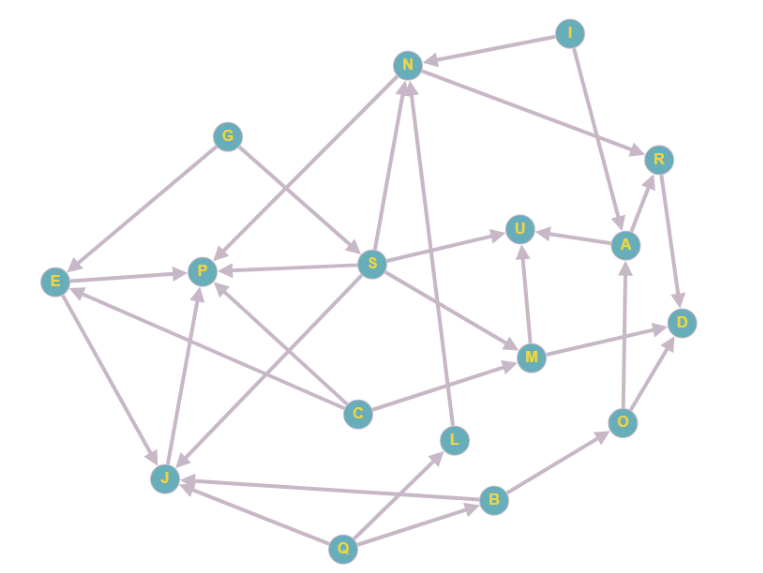

#Математические выкладки

Как было подмечено в условии задачи B, в графе не всегда существует гамильтонов путь, таким образом на практике важнее оказывается отыскание максимального пути в ориентированном графе - пути, посещающим максимальное кол-во вершин ориентированого графа без повторений. Так как задача является обобщением поиска гамильтонова пути, то и решение можно попытаться получить из предыдущей задачи обобщением, чем и займемся.

Пусть наш ориентированный граф имеет матрицу смежности $w$, а для кодирования пути будем использовать $N^2$ битов, где $x_{i,p} = 1$ если на p-ом шаге мы посетили i-ую вершину и 0 иначе. Эти биты можно трактовать как график траектории по нашему графу. Для этого необходимы некоторые ограничения, которые мы реализуем через штрафы:

$H_p = \sum_{k,i,j}^{N-1}(1 - 2\delta_{i,j})x_{i,k}x_{j,k}$ - гарантирует, что на любом шаге мы будем ровно в одном городе.
$H_w = \sum_{k=0}^{N - 2} \sum_{i,j=0}^{N - 1} (1 - w_{ij}) x_{i,k} x_{j, k+1}$ - штрафует за переходы не по ребру 

$H_v = \sum_{i,k,l}^{N-1}(1-2\delta_{k,l})x_{i,k}x_{i,l}$  - заставляет нашу траеторию пройти через все города по одному разу.

Как видно из формулировки штрафов минимум достигается на гамильтоновом пути. Но в случае, когда его нет мы не можем корректно проинтерпретировать полученный ответ. Так как теперь мы ищем не гамильтонов путь, а максимальный, то модифицируем наши штрафы.
Во первых теперь мы пожем не посещать некоторые вершины, так что соотвествующий штраф мы переформулируем так:

$H_v = \sum_{p<q}^{N-1}\sum_{i = 1}^{N-1}x_{i,p}x_{i,q}$ - подобный штраф позволяет нам посетить город 0 или 1 раз.

Но это все еще не позволяет нам менять кол-во шагов, которые мы делаем. Если длина максимального пути меньше N, то траектория либо побывает в одной вершине дважды, либо перейдет не по ребру, что не допустимо. Для решения этой проблемы можно добавить еще одну "домашнюю" вершину, в которой наша траектория может отсидеться лишние шаги. Для того, чтобы это не влияло на путь, сделаем так, чтоб из нее можно было перейти в любую другую вершину, при этом вернуться в нее было нельзя. 
Для того, чтобы это сработало необходимо так же убрать штраф за повторное нахождение там - вернуться домой траектория все равно не сможет. При этом оказывается, что ей выгодно не покидать эту инициальную вершину, так что для этого добавим еще один штраф за повторы, но не такой сильный, как $H_v$. 
Ниже представлены финальная версия штрафов:
$H_w = \sum_{k=0}^{N - 2} \sum_{i,j=0}^{N - 1} (1 - w_{ij}) x_{i,k} x_{j, k+1}$ - для корректности переходов

$H_v = \sum_{p<q}^{N-1}\sum_{i = 1}^{N-1}x_{i,p}x_{i,q}$ - штрафует за повторное посещение вершин, игнорируя домашнюю

$H_p = \sum_{k,i,j}^{N-1}(1 - 2\delta_{i,j})x_{i,k}x_{j,k}$ - не дает траеткории быть в двух вершинах одновременно. 

Целевой функцией мы возьмем кол-во шагов, которое траектория находится в домашней вершине:

$H_I = \sum_{k = 1}^{N - 1}x_{0,k}^{2}$

Тогда $Q = H_I + \alpha(H_w + H_v + H_p)$, где параметр $\alpha$ выбирается эмпирически и характеризует насколько условия жесткие.
В случае правильной настройки минимум будет максимальным по длине корректным путем без повторений, что и требовалось в первоначальной задаче.

#Генерация QUBO задачи


In [7]:
#модифицируем граф и матрицу смежности
A = np.zeros((N+1, N+1)) 
A[0,0] = 1
for i in range(N):
  for j in range(N):
    A[0, j+1] = 1
    A[i+1, j+1] = w[i,j]

N = N + 1
w = A

**Новый граф**


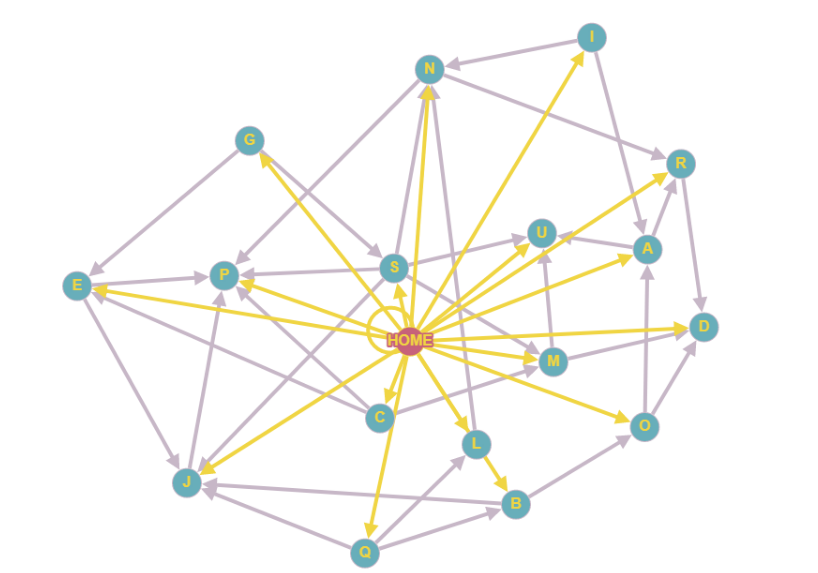

In [8]:
#генерация матриц со штрафами
H_w = np.zeros((N**2, N**2))
for k in range(N - 1):
    for i in range(N):
        for j in range(N):
            H_w[N*i + k, N*j + (k + 1) % N ] = 1 - w[i, j]

H_v = np.zeros((N**2, N**2))
for i in range(1,N):
  for q in range(1,N):
    for p in range(q):
      H_v[N*i + p, N*i + q] = 1

H_p = np.zeros((N**2, N**2))
for k in range(N):
  for i in range(N):
    for j in range(N):
      H_v[N*i + k, N*j + k] = 1 - 2 * int(i == j)

H_I = np.zeros((N**2, N**2))
for k in range(1,N):
    H_I[k, k] = 1           

In [9]:
#формулировка и решение задачи QUBO 
alpha = 10
Q = alpha * (H_w + H_v + H_p) + H_I
solver_name = 'gurobi'
s = Solver(mode=f"remote:{solver_name}", params=PARAMS)
spins, energy = s.solve_qubo(Q, timeout=30)
spins, energy
lenght = int(N-1 - (energy + N * alpha) )
print("lenght =", lenght, "error =", N + np.dot(spins,np.dot(H_w + H_v + H_p, spins)))
path = np.argmax((np.array(spins)).reshape((N,N)), axis = 0)[:-lenght-1:-1][::-1] - 1
print(letters[path[0]], end = "")
for i in range(1,lenght):
  print(" ->",letters[path[i]], end = "")

[2021-10-23 22:26:39] Solver remote:gurobi started
[2021-10-23 22:26:40] Server status - 0 active tasks
[2021-10-23 22:26:40] Start matrix upload
[2021-10-23 22:26:41] Upload completed, start solving
[2021-10-23 22:26:42] Found solution 0.000000 
[2021-10-23 22:26:42] Found solution -164.000000 
[2021-10-23 22:26:42] Found solution -165.000000 
[2021-10-23 22:26:44] Found solution -166.000000 mipgap=0.9939258555481729
[2021-10-23 22:26:47] Found solution -167.000000 mipgap=0.9819142540087253
[2021-10-23 22:27:12] Solver completed, solution type - feasible mipgap=0.812410293081468
lenght = 4 error = 0.0
Q -> L -> N -> P

**Максимальный путь на данном графе**

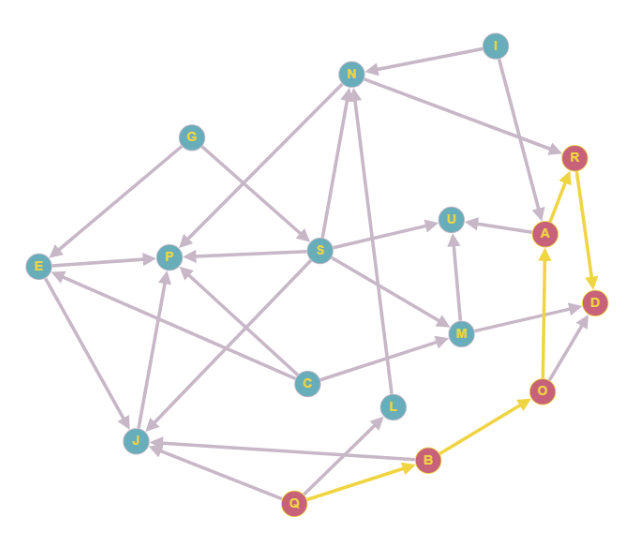